# RFM Clustering & Customer Intelligence
## Objective

This notebook builds on the EDA phase and focuses on customer segmentation using RFM metrics and unsupervised learning. The objective is to identify economically meaningful customer groups that support strategic decisions in marketing, operations, and inventory management.

Scope of this notebook:

- RFM feature engineering

- Scaling and clustering (K-Means)

- Cluster validation

-  Business-oriented segment interpretation

# 1. Environment Setup

In [24]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# 2. Project Paths & Data Loading

In [27]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.feature_engineering import (
    calculate_rfm_metrics,
    prepare_rfm_for_clustering
)

DATA_PATH = os.path.join(
    PROJECT_ROOT, "data", "processed", "cleaned_retail_data.csv"
)

df = pd.read_csv(DATA_PATH, parse_dates=["InvoiceDate"])

df["TotalSum"] = df["Quantity"] * df["Price"]

# 3. RFM Feature Engineering

RFM metrics capture three key dimensions of customer value:

- Recency: How recently a customer purchased

- Frequency: How often they purchase

- Monetary: How much revenue they generate

In [28]:
rfm = calculate_rfm_metrics(df)
rfm.head()

rfm.head()

✅ RFM metrics calculated for 5797 unique customers.


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,529,11,372.86
12347.0,2,8,5377.72
12348.0,75,5,1057.24
12349.0,19,3,3498.94
12350.0,310,1,294.40


# 4. Scaling & Distribution Check
RFM variables are highly skewed and require normalization before clustering.

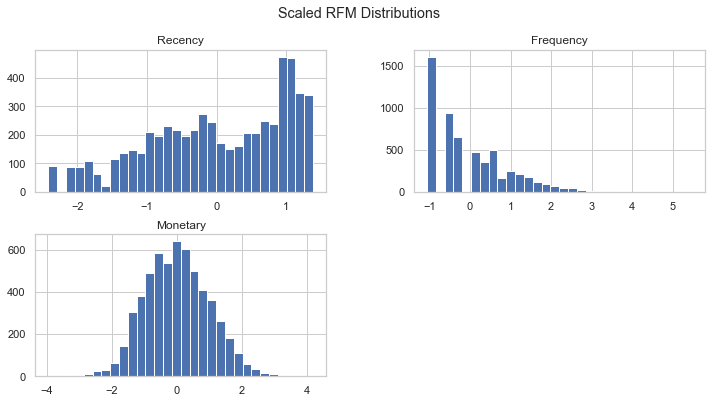

In [29]:
from sklearn.preprocessing import StandardScaler

rfm_scaled, scaler = prepare_rfm_for_clustering(rfm)

rfm_scaled.hist(bins=30)
plt.suptitle("Scaled RFM Distributions")
plt.show()

# 5. K-Means Clustering

In [ ]:
# Model training 

kmeans = KMeans(
    n_clusters=4,
    init="k-means++",
    n_init=10,
    random_state=42
)

rfm["Cluster_ID"] = kmeans.fit_predict(rfm_scaled)

# --- Cluster Validation
silhouette = silhouette_score(rfm_scaled, rfm["Cluster_ID"])
print(f"Silhouette Score: {silhouette:.3f}")

Silhouette Score:0.367
Silhouette Score: 0.367


Interpretation:

- Values > 0.3 indicate acceptable separation for behavioral data

# 6. RFM-Based Business Scoring
To translate clusters into business-readable segments, we compute quintile-based RFM scores

In [31]:
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1]).astype(int)
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1,2,3,4,5]).astype(int)

# 7. Segment Definition (Business Logic)

In [ ]:
def assign_segment(row):
    r, f, m = row["R_Score"], row["F_Score"], row["M_Score"]
    if r >= 4 and f >= 4 and m >= 4:
        return "Champions (VIP)"
    elif m >= 4 and r >= 3:
        return "Big Spenders"
    elif r <= 2:
        return "At Risk / Hibernating"
    else:
        return "Core Customers"


rfm["Segment"] = rfm.apply(assign_segment, axis=1)

rfm["Segment"].value_counts(normalize=True) * 100


Segment
At Risk / Hibernating    39.917199
Core Customers           26.806969
Champions (VIP)          22.183888
Big Spenders             11.091944
Name: proportion, dtype: float64

# 9. 3D RFM Segment Visualization

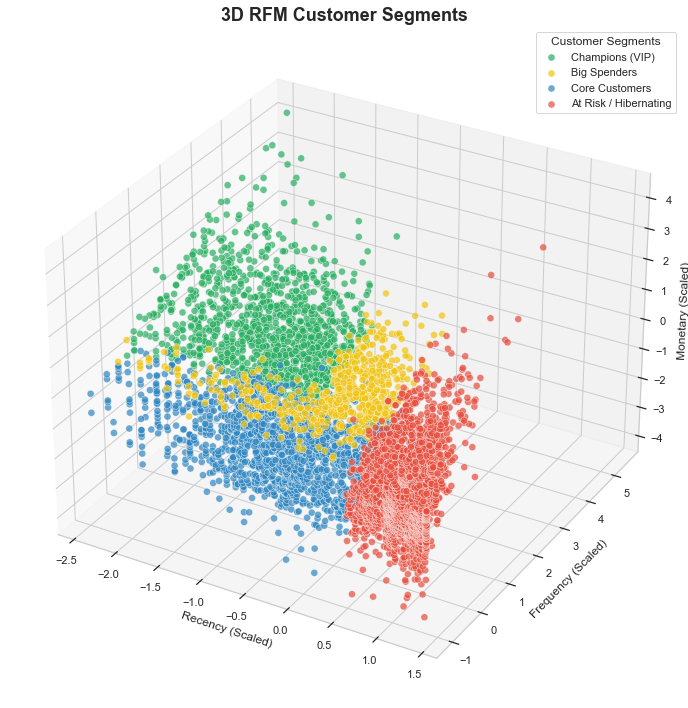

In [33]:

segment_colors = {
    "Champions (VIP)": "#27AE60",
    "Big Spenders": "#F1C40F",
    "Core Customers": "#2E86C1",
    "At Risk / Hibernating": "#E74C3C"
}

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection="3d")

for segment, color in segment_colors.items():
    mask = rfm["Segment"] == segment
    ax.scatter(
        rfm_scaled.loc[mask, "Recency"],
        rfm_scaled.loc[mask, "Frequency"],
        rfm_scaled.loc[mask, "Monetary"],
        c=color,
        label=segment,
        s=50,
        alpha=0.7,
        edgecolors="white",
        linewidth=0.5
    )

ax.set_title(
    "3D RFM Customer Segments",
    fontsize=18,
    fontweight="bold"
)

ax.set_xlabel("Recency (Scaled)")
ax.set_ylabel("Frequency (Scaled)")
ax.set_zlabel("Monetary (Scaled)")

ax.legend(title="Customer Segments")
plt.tight_layout()
plt.show()

# 10. Cluster & Segment Consistency

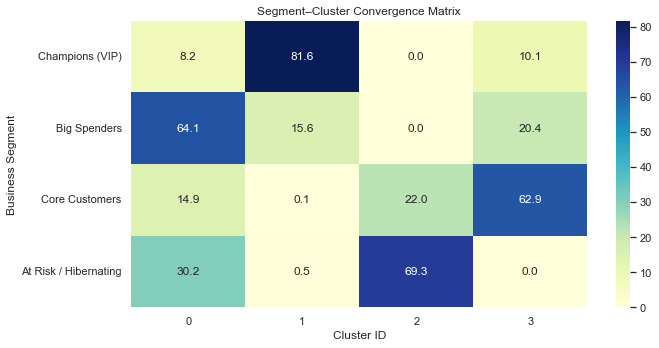

In [ ]:

order = [
    "Champions (VIP)",
    "Big Spenders",
    "Core Customers",
    "At Risk / Hibernating"
]

convergence = (
    pd.crosstab(rfm["Segment"], rfm["Cluster_ID"], normalize="index") * 100
)

plt.figure(figsize=(10, 5))
sns.heatmap(
    convergence.reindex(order),
    annot=True,
    fmt=".1f",
    cmap="YlGnBu"
)

plt.title("Segment–Cluster Convergence Matrix")
plt.xlabel("Cluster ID")
plt.ylabel("Business Segment")
plt.tight_layout()
plt.show()

This matrix validates the alignment between statistical clusters and business rules.

# 11. Strategic Interpretation

- Champions (VIP): High value, low churn risk → retention priority

- Big Spenders: High monetary, moderate frequency → upsell potential

- Core Customers: Stable revenue base → operational backbone

- At Risk: Declining engagement → reactivation candidates

# 12. Next Step

➡ Proceed to Inventory & ABC Impact Analysis to connect customer behavior with stock and revenue concentration.

This modular design keeps modeling interpretable, auditable, and decision-oriented.

# 13. Save models

In [36]:
import joblib

models_path = '../models'
if not os.path.exists(models_path): os.makedirs(models_path)
joblib.dump(model_2011, os.path.join(models_path, 'rfm_kmeans_2011.pkl'))
joblib.dump(scaler_2011, os.path.join(models_path, 'rfm_scaler_2011.pkl'))

print(f"✅ Side-by-Side Analysis Complete. Values adjusted for inflation.")

✅ Side-by-Side Analysis Complete. Values adjusted for inflation.
